In [ ]:
#导入包
import backtrader as bt
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#分析模块
import backtrader.analyzers as btanalyzers
import math
import tushare as ts
import config

In [ ]:
#config文件(同一文件夹另一.py文件)
token = "123456789"

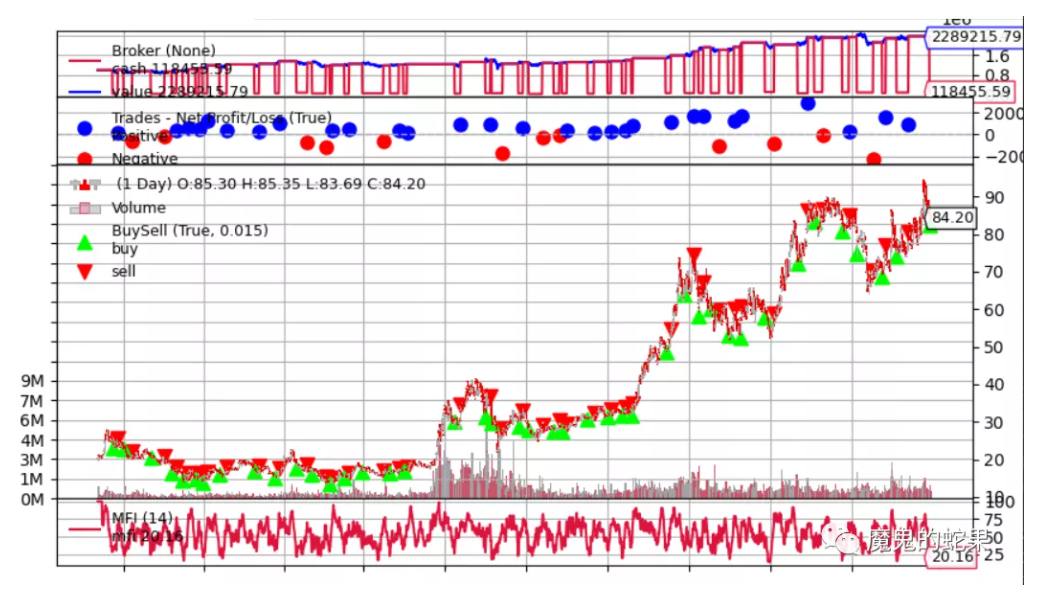

In [ ]:
#MFI策略
#继承Indicator--指标
class MFI(bt.Indicator):
    #https://www.investopedia.com/terms/m/mfi.asp 查看
    lines = ("mfi", "raw_mf", "typical", "money_flow_pos", "money_flow_neg")

    #关掉一些线  不用把线画出来
    plotlines = dict(
        raw_mf = dict(_plotskip=True),
        money_flow_pos = dict(_plotskip=True),
        money_flow_neg = dict(_plotskip=True),
        typical = dict(_plotskip=True),
    )
    #定义期限 14天  元组 不能只有一个元素 要加，
    params = (
        ('period', 14),
    )

    def next(self):
        #0当天的数据 -1前一天数据
        typical_price = (self.data.close[0] + self.data.low[0]+self.data.high[0])/3
        raw_mf = typical_price * self.data.volume[0]

        #上面是点的数据  我们把它加入一列的数据(把点连成线)
        self.lines.typical[0] = typical_price
        self.lines.raw_mf[0] = raw_mf
        
        #运算过去14天正向的money_flow    大于昨天记住
        self.lines.money_flow_pos[0] = raw_mf if self.lines.typical[0] >= self.lines.typical[-1] else 0
        self.lines.money_flow_neg[0] = raw_mf if self.lines.typical[0] <= self.lines.typical[-1] else 0
    
        #把里面的数据加起来
        pos_mf = math.fsum(self.lines.money_flow_pos.get(size=self.params.period))
        neg_mf = math.fsum(self.lines.money_flow_neg.get(size=self.params.period))
        
        #错误处理
        if neg_mf == 0:
            self.lines.mfi[0] = 100
            return
        #Money Flow Index
        self.lines.mfi[0] = 100 - 100/(1+ pos_mf/neg_mf)


In [ ]:
#Backtrader的回测框架：(策略运行部分)
class Strategy(bt.Strategy):
    #给一个记录 记录交易的时间 将时间存入txt文件中
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    #初始化一下
    def __init__(self):
        self.mfi = MFI()
        
    #记录交易执行情况（默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: {:.2f}, Cost: {:.2f}, Comm {:.2f}'.format(
                        order.executed.price,#价格
                        order.executed.value,#成本
                        order.executed.comm))#手续费

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: {:.2f}, Cost: {:.2f}, Comm {:.2f}'.format(
                    order.executed.price,
                    order.executed.value,
                    order.executed.comm))
            #交易过程的大小存储起来
            self.bar_executed = len(self)
        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm)) #毛收益 净收益
    #具体策略执行层
    def next(self):
        if not self.position:
            #如果没有仓位
            if self.mfi[0]<35:
                #下个单 买95%
                self.order = self.order_target_percent(target=0.95)
        else:
            #有仓位 卖掉 >65 超仓
            if self.mfi[0] > 65:
                self.order = self.sell()

In [ ]:
#main程序
if __name__=='__main__':
    stock = '601318.SH'
    start_date = '20100701'
    end_date = '20201224'
    ts.set_token(config.token)

    #这是获取股票601318从2010年7月1号到2020年12月24号的所有前复权数据的代码
    def aquire_data(stock, start_date, end_date):
        df = ts.pro_bar(ts_code=stock,adj='qfq', start_date=start_date, end_date=end_date)
        #将时间转化为时间组的形势 2020-10-02
        dates = pd.to_datetime(df['trade_date'])
        df = df[['open', 'high', 'low', 'close', 'vol']]
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df.index = dates
        #时间升序排列 创建新的实例
        df.sort_index(ascending=True, inplace=True)
        return df

    df = aquire_data(stock, start_date, end_date)
    #backtrader()大脑
    cerebro = bt.Cerebro()
    #提取数据 数据类型为dataframe 数据名称为df
    data = bt.feeds.PandasData(dataname=df)
    #加入数据和strategy
    cerebro.adddata(data)
    cerebro.addstrategy(Strategy)

    #设定开始价格为1000000
    cerebro.broker.setcash(1000000)
    #设定佣金为0
    cerebro.broker.setcommission(commission=0)
    #设定交易多少 98% 设置每笔交易交易的股票数量
    cerebro.addsizer(bt.sizers.PercentSizer, percents=98)

    back = cerebro.run()
    #画出类型为"candle"的图像
    cerebro.plot(style='candle')